In [1]:
import sys
sys.path.append('..')

from common.utility import show_implementation
from module.utility import show_images

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
rose_image = Image.open('images/rose.jpg').resize((288, 216))
rose_image_rgb = np.array(rose_image.convert('RGB'))

woman_image = Image.open('images/woman.jpg').resize((288, 216))
woman_image_grey = np.array(woman_image.convert('L'))

In [3]:
shape_image = Image.open('images/shapes.png')
shape_image = np.array(shape_image.convert('L'))

# Key Points
## Motivation

Suppose that, given a set of images that are taken a distance apart in the scene, we wish to join them together to form one big image.
That is, suppose that we are trying to recreate the panorama feature on smart phones.

To do so, we need to do the following for each pair of images to match:
1. Find locations to match
2. Have a representation of the surrounding region
3. Perform the matching

## Characteristics of Good Local Features
* Repeatable interest points
    * The same point can be found in other images, regardless of geometric and photometric transformations
        * Geometric: Rotation/Scale changes
        * Photometric: Intensity changes
* Distinct descriptors
    * Captures distinctively different information for each different points of interest
* Efficient
    * Number of features much be much less than the number of pixels in the image
* Local
    * Feature should occupy a small area of image

### Distinct Descriptors
Consider the the image below.

In [126]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


def show_shift(rect=(0,0,0,0), shift=(0,0,0,0), plain=False):
    fig, ax = plt.subplots(figsize=[6.4, 4.8])

    ax.plot((1, 1, 2), (0, 3, 1))
    ax.set_xlim((0, 5))
    ax.set_ylim((0, 5))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if not plain:
        for i, c, loc in zip((1, 4), ("red", "green"), ((2, 4), (1, 3))):
            axins = zoomed_inset_axes(ax, 2, loc=i)

            axins.plot((1, 1, 2), (0, 3, 1))

            x1, x2, y1, y2 = rect

            if i > 1:
                dx, dy = shift
                x1, x2, y1, y2 = x1 + dx, x2 + dx, y1 + dy, y2 + dy

            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins.xaxis.set_visible(False)
            axins.yaxis.set_visible(False)

            mark_inset(ax, axins, loc1=loc[0], loc2=loc[1], edgecolor=c)

            plt.xticks(visible=False)
            plt.yticks(visible=False)
    plt.draw()
    plt.show()

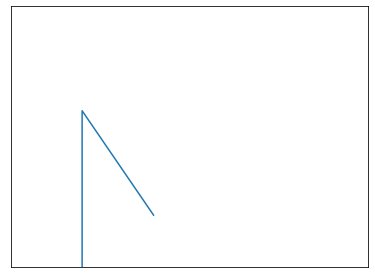

In [129]:
show_shift(plain=True)

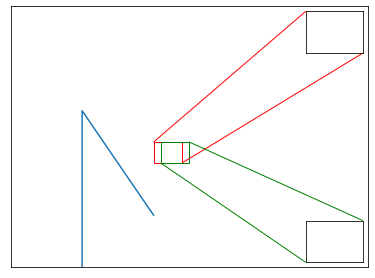

In [133]:
show_shift((2, 2.4, 2, 2.4), (0.1, 0))

Suppose that we are considering the flat region in the image, as above.
Notice that if we shift the window in any direction slightly, the content in the window will not change.
This means this region is **not distinct**.

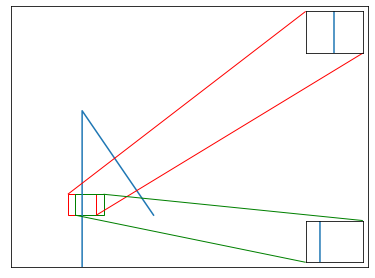

In [135]:
show_shift((0.8, 1.2, 1, 1.4), (0.1, 0))

Now suppose that we instead are considering the region along the vertical line.
Notice that a (small) horizontal shift will change the content in the window, but a (small) vertical shift will not cause any change.

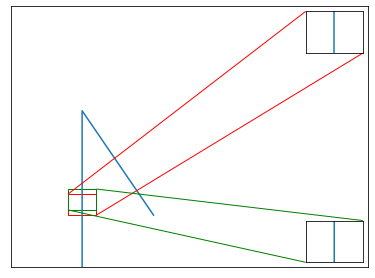

In [136]:
show_shift((0.8, 1.2, 1, 1.4), (0, 0.1))

But notice a (small) vertical shift will not cause any change.

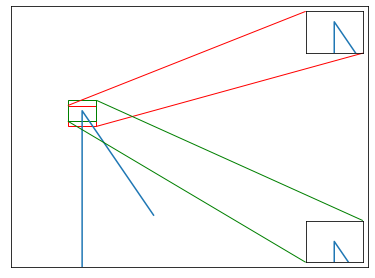

In [141]:
show_shift((0.8, 1.2, 2.7, 3.1), (0, 0.1))

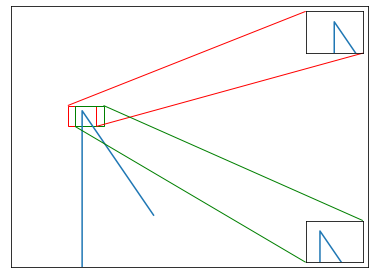

In [142]:
show_shift((0.8, 1.2, 2.7, 3.1), (0.1, 0))

Now consider the window that contains a corner.
Because of this corner, a shift in any direction will change the location of this corner in the window. 
This means that this location is distinct and is what we are looking for.

## How to detect corners?

Suppose we shift a $x \times y$ window $W$ by an offset of $(u, v)$.
To compute the difference of each pixel after shifting, we get:

$$
E(u,v) = \sum _{(x, y) \in W} (I(x+u, y+v) - I(x, y)) ^2
$$

For a good descriptor, we wish for this error to be high.

However, notice that this would require a lot of computation since we would need to compute the difference in windows for each pixel.
Thus, we make some assumptions.

We only consider the cases when the shifts are small.
This allows us to use the following Taylor Series approximation:

$$
I(x+u, y+v) = I(x,y) + \frac{\partial I}{\partial x} u + \frac{\partial I}{\partial y} v + \text {higher order terms} \\
\approx  I(x,y) + \frac{\partial I}{\partial x} u + \frac{\partial I}{\partial y} \\
=  I(x,y) + I_x u + I_y v
$$

Therefore, we get:

$$
E(u,v) = \sum _{(x, y) \in W} (I(x+u, y+v) - I(x, y)) ^2 \\
= \sum _{(x, y) \in W} (I(x,y) + I_x u + I_y v- I(x, y)) ^2
= \sum _{(x, y) \in W} (I_x u + I_y v) ^2\\
= Au^2 + 2Buv + Cv^2\\
\text{where } A = \sum _{(x, y) \in W} I_x^2, \quad B = \sum _{(x, y) \in W} I_x I_y, \quad C = \sum _{(x, y) \in W} I^2_y
$$

We can also write the expression as 

$$E(u,v) = 
\begin{pmatrix}
u & v
\end{pmatrix}
\begin{pmatrix}
A & B \\ B & C
\end{pmatrix}
\begin{pmatrix}
u \\ v
\end{pmatrix}
$$

We call the matrix $H=
\begin{pmatrix}
A & B \\ B & C
\end{pmatrix}$ the second moment matrix

It is known that quadratic functions can be visualized as ellipses.
In this case, $H$ will control the shape of the ellipse, where the eigenvectors of $H$ will control the orientation, and the eigenvalues will control the length of the axes.

You can read up more about eigenvalues/eigenvectors [here](../linear-algebra/eigen.ipynb)

Using the formula there, we know that the eigenvalues for a $2\times2$ matrix $\begin{pmatrix}
a & b \\ c & d
\end{pmatrix}$
is:

$$
\lambda _\pm = \frac{1}{2}\left( a + d \pm \sqrt {4bc + (a - d)^2}\right)
$$

Hence, the larger eigenvalue corresponds to the direction of the largest increase in error, while its eigenvalue correspond to the amount of increase in that direction.
Similarly, the smaller eigenvector corresponds to the smallest increase.

This means that when only one of the eigenvalue is zero, it means that we are in a region along an straight edge.

And if both are zero, we are in the flat region.

### Finding Corners
Thus, it becomes straightforward that we wish to find areas where the smaller eigenvalue is large, as those will correspond to regions which gives large changes in the window regardless of shift direction.

In [8]:
from module.gradient import compute_one_gradient
from module.kernel import Orientation
from module.convolve import convolve

def _ev(a, b, c, d):
    return 0.5 * (a + d - np.sqrt(4 * b * c + (a - d) ** 2)), 0.5 * (a + d + np.sqrt(4 * b * c + (a - d) ** 2))

def eig(image, window_size=5, kappa=0.05, window=None):
    Ix = compute_one_gradient(image, Orientation.horizontal)
    Iy = compute_one_gradient(image, Orientation.vertical)

    w = np.ones((window_size, window_size)) if window is None else window

    A = convolve(Ix**2, w, clip=False, pad=False)
    B = convolve(Ix*Iy, w, clip=False, pad=False)
    C = convolve(Iy**2, w, clip=False, pad=False)
    
    return _ev(A, B, B, C)

ev1, ev2 = eig(shape_image)

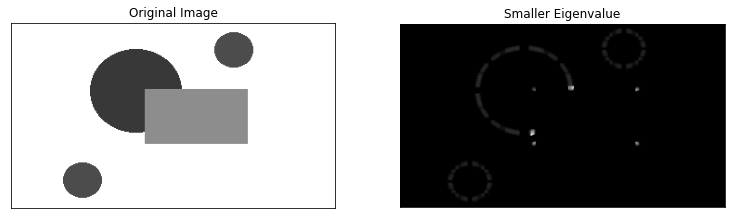

In [9]:
show_images([(shape_image, "Original Image"), (ev1, "Smaller Eigenvalue", True)])

---
#### Side note

The larger eigenvalue does also gives us some "interesting" results (strikingly similar to an edge detector), as shown below.

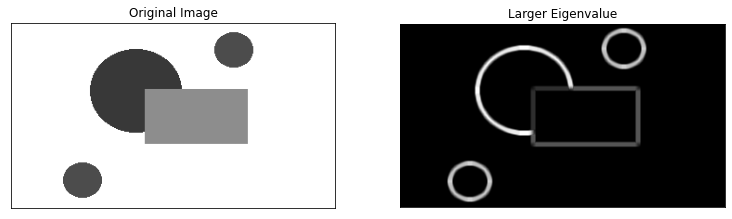

In [10]:
show_images([(shape_image, "Original Image"), (ev2, "Larger Eigenvalue", True)])

---

With this, we do indeed locate the corners in the image.

However, finding eigenvalue is a slow process, since we need to compute roots.
We can use the following approximation using the **Harris operator**, defined as:

$$
R = \det H - \kappa \text{trace}^2 H
$$

where
$$
\det H = \lambda_1 \lambda_2, \quad \text{trace} H = \lambda_1 + \lambda_2,  \quad 0.04 \leq \kappa \leq 0.06 
$$

By linear algebra, we also know that $\det H = AC - B^2$, and trace $H = A + C$, which speeds up our computation.

In [11]:
from module.corners import harris
show_implementation(harris)

def harris(image, window_size=5, kappa=0.05, window=None):
    Ix = compute_one_gradient(image, Orientation.horizontal)
    Iy = compute_one_gradient(image, Orientation.vertical)

    w = np.ones((window_size, window_size)) if window is None else window

    A = convolve(Ix**2, w, clip=False, pad=False)
    B = convolve(Ix*Iy, w, clip=False, pad=False)
    C = convolve(Iy**2, w, clip=False, pad=False)

    det = A * C - B ** 2
    tr = A + C

    R = det - 0.05 * tr ** 2

    return R


In [12]:
R = harris(shape_image)

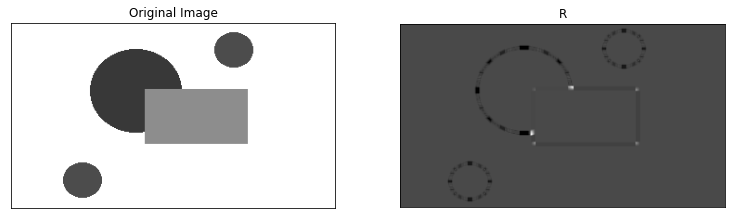

In [13]:
show_images([(shape_image, "Original Image"), (R, "R", True)])

As we can see, we indeed get a high response at the corners of the rectangle.

Usually, to get better effects, we would weight the derivatives based on their distance from the center pixel.
Once again, notice that this simply correspond to filtering with a Gaussian filter, as shown below.

In [14]:
from module.kernel import gaussian_filter
R = harris(shape_image, window=gaussian_filter(5))

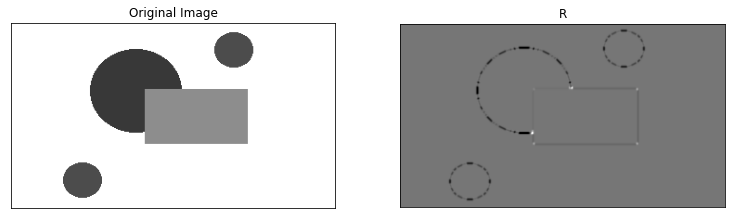

In [15]:
show_images([(shape_image, "Original Image"), (R, "R", True)])

For completeness, we can compare the results we get from computing the smaller eigenvalue and using the Harris operator.

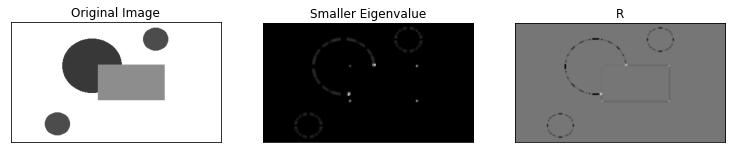

In [16]:
show_images([(shape_image, "Original Image"), (ev1, "Smaller Eigenvalue", True), (R, "R", True)])

In [17]:
R.shape

(194, 344)

In [18]:
194/344

0.563953488372093

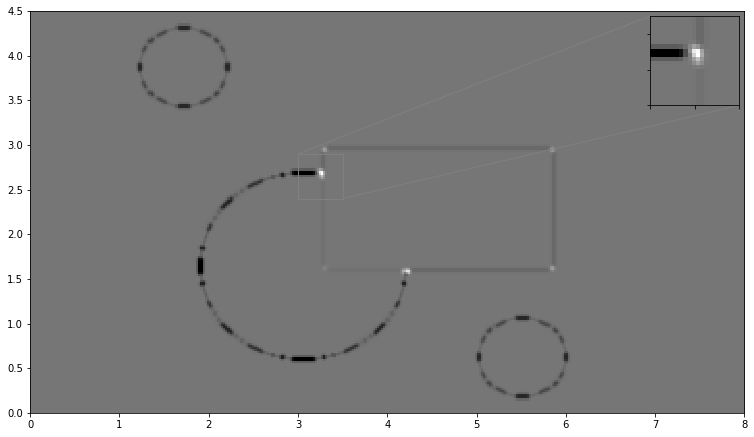

In [46]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=[12.8, 9.6])

extent = [0, 8, 0, 4.5]
ax.imshow(R, extent=extent, interpolation="nearest",
          origin="lower", cmap="gray")

axins = zoomed_inset_axes(ax, 2, loc=1)
axins.imshow(R, extent=extent, interpolation="nearest",
             origin="lower", cmap="gray")

x1, x2, y1, y2 = 3, 3.5, 2.4, 2.9
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=False)
plt.yticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.draw()
plt.show()

### Non-Maximum Suppression


### Properties of Harris corners
